# Process industrial site data from the [Industrial Emissions Directive 2010/75/EU and European Pollutant Release and Transfer Register Regulation (EC) No 166/2006](https://www.eea.europa.eu/data-and-maps/data/industrial-reporting-under-the-industrial), taking waste quantity as a proxy of industrial site size

In [2]:
import sys
import os

import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt 

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../src/construct/')
import util

idx = pd.IndexSlice

data_path = '../data/industry'

In [3]:
industrial_activity_codes = pd.read_csv(
    data_path + '/industry_activity_codes.csv', 
    skipfooter=7, index_col=0, header=0, engine='python'
).dropna(subset=['Eurostat sector'])

waste_df = pd.read_csv(data_path + '/waste.csv')
points = [Point(xy) for xy in zip(waste_df.pointGeometryLon, waste_df.pointGeometryLat)]
waste_gdf = gpd.GeoDataFrame(geometry=points, data=waste_df[['countryCode', 'mainActivityCode', 'totalWasteQuantityTNE']], crs='epsg:4326')
waste_gdf['mainActivityCode'] = waste_gdf.mainActivityCode.map(industrial_activity_codes['Eurostat sector'])
waste_gdf = waste_gdf.dropna(subset=['mainActivityCode']).rename(columns={'countryCode': 'country_code', 'mainActivityCode': 'subsector', 'totalWasteQuantityTNE': 'waste'})

In [4]:
# save
waste_gdf.to_file('../build/industry_eprtr_waste_sites.geojson', driver='GeoJSON')

(1400000.0, 5500000.0)

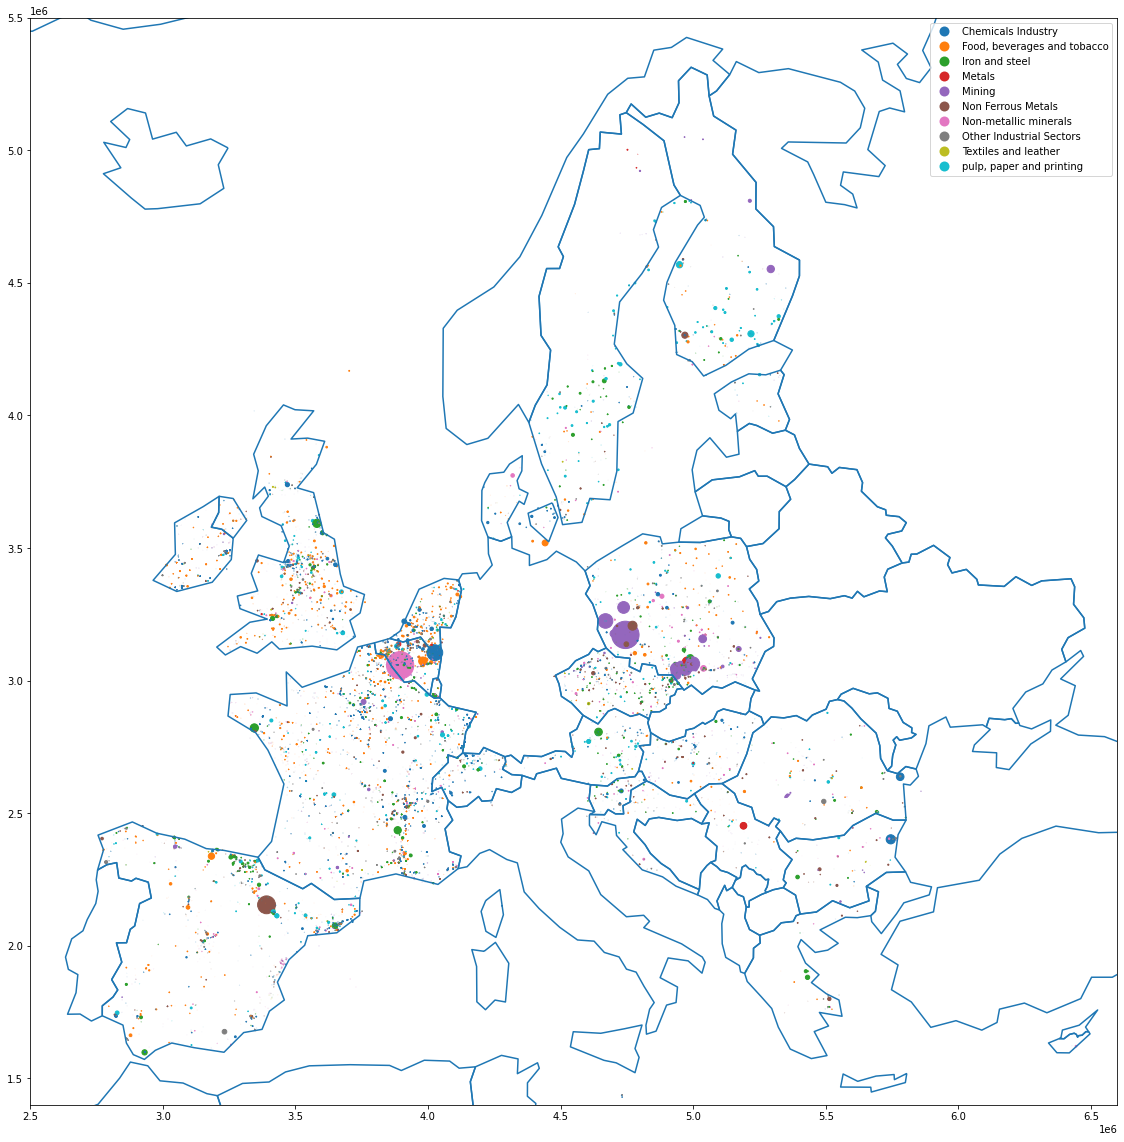

In [8]:
# Show sites
waste_gdf['waste_10kT'] = waste_gdf['waste'] / 1e4
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')).to_crs('epsg:3035')
ax = world.boundary.plot(figsize=(20,20))
waste_gdf.to_crs('epsg:3035').plot('subsector', markersize='waste_10kT', ax=ax, legend=True)
ax.set_xlim(0.25e7, 0.66e7)
ax.set_ylim(0.14e7, 0.55e7)